In [4]:
import glob
a = glob.glob('../../../../../home/saifulislam/work/physionet/physionet2024/python-example-2024-main/physionet.org/files/ptb-xl/1.0.3/records100/gen_full_clean_h/*.png')[0]

In [5]:
a

'../../../../../home/saifulislam/work/physionet/physionet2024/python-example-2024-main/physionet.org/files/ptb-xl/1.0.3/records100/gen_full_clean_h/04427_lr-0.png'

In [6]:
from PIL import Image

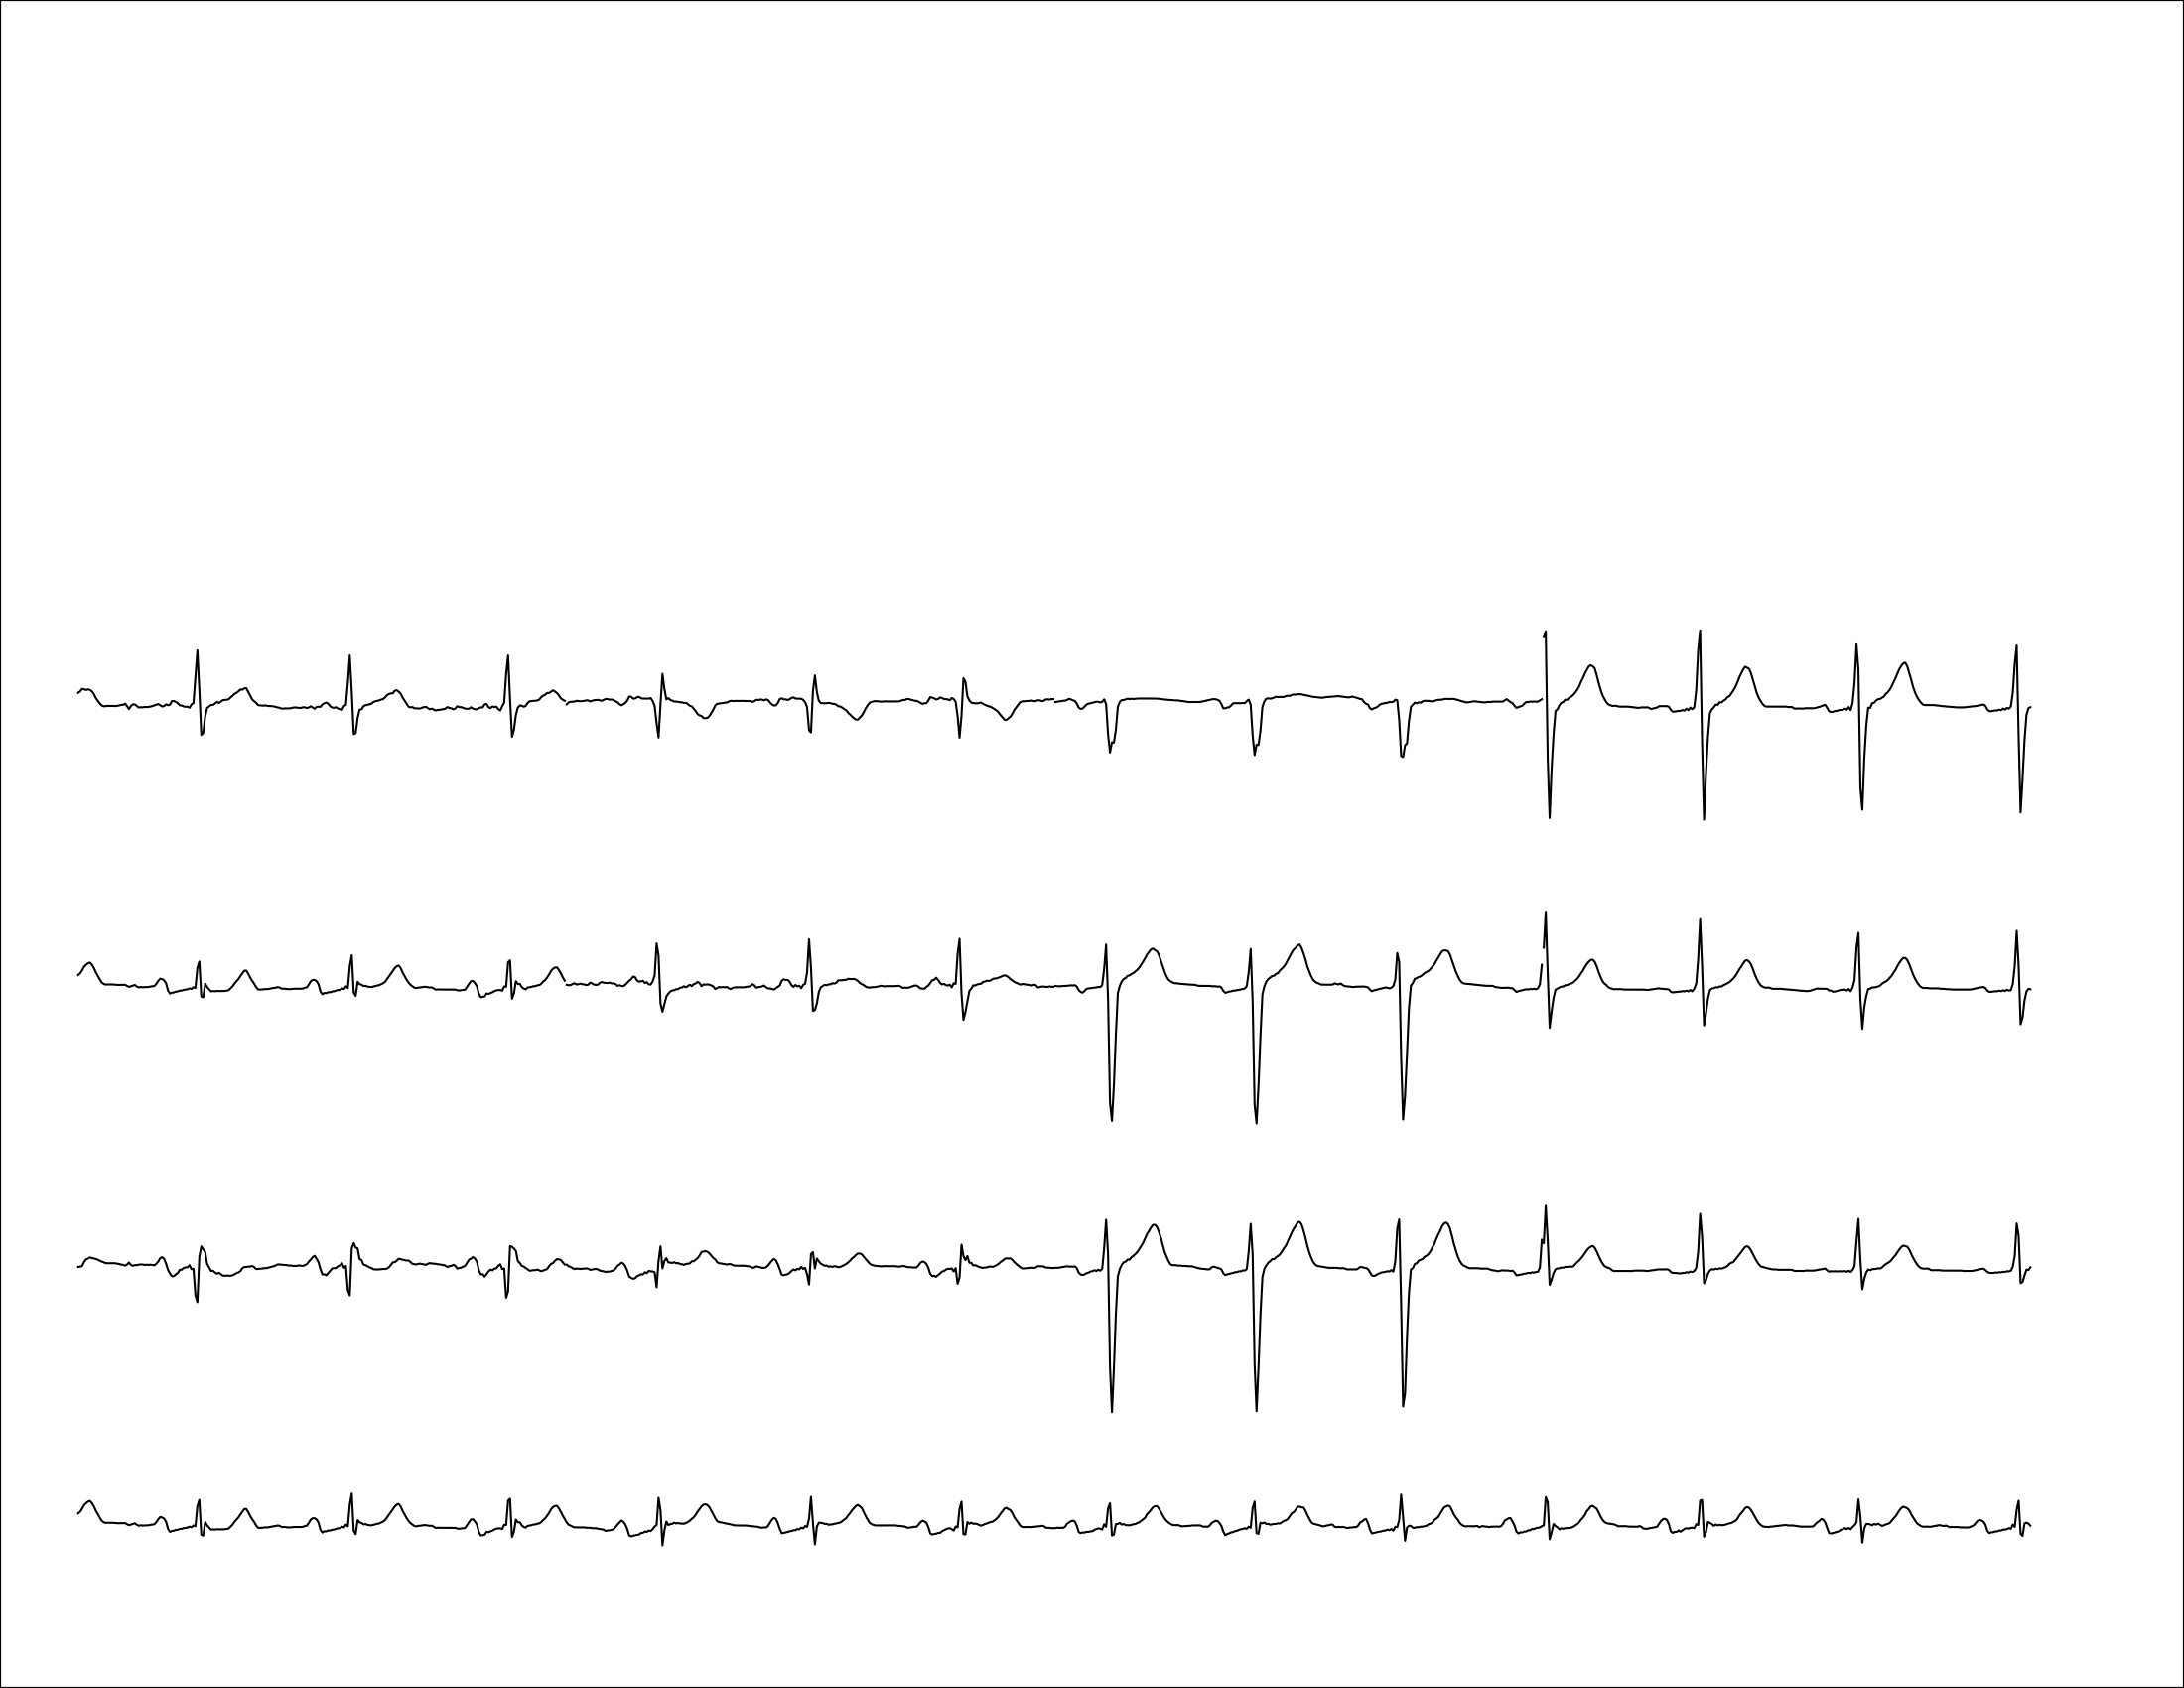

In [7]:
Image.open(a)

In [8]:
import os
import shutil

import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import argparse
import re
import pandas as pd
import numpy as np

from helpers import makedir
import model_for_superclasses as model
import push
import train_test_inference as tnt
import save
from log import create_logger
from preprocess import mean, std, preprocess_input_function

In [9]:
labels = [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
 [0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0.],
 [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
 [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
 [0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
 [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
 [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
 [0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
 [0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
 [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
 [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
 [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
 [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
 [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
 [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
 [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]]

In [10]:
scores = [[0.00002161, 0.00002477, 0.00002316, 0.00002694, 0.00002277, 0.00002238,
  0.00002337, 0.00002399, 0.00002398, 0.00002307, 0.00002554],
 [0.00002634, 0.000029  , 0.00002724, 0.00003196, 0.00002652, 0.00002653,
  0.00002785, 0.0000293 , 0.00002898, 0.00002844, 0.00003101],
 [0.00002192, 0.0000245 , 0.00002304, 0.00002659, 0.00002221, 0.00002254,
  0.00002339, 0.00002499, 0.00002441, 0.0000232 , 0.00002584],
 [0.00002941, 0.00003156, 0.0000289 , 0.00003523, 0.00002902, 0.00002939,
  0.00003079, 0.00003209, 0.00003163, 0.00003088, 0.00003412],
 [0.00002881, 0.00003155, 0.000029  , 0.00003471, 0.0000288 , 0.0000288 ,
  0.0000303 , 0.00003132, 0.00003183, 0.00003071, 0.00003394],
 [0.00003022, 0.00003229, 0.00002978, 0.00003607, 0.00002969, 0.00002999,
  0.00003146, 0.00003244, 0.00003237, 0.00003131, 0.00003462],
 [0.00003062, 0.00003336, 0.00003144, 0.00003709, 0.00003121, 0.00003124,
  0.00003284, 0.00003365, 0.00003363, 0.00003202, 0.00003615],
 [0.00003025, 0.00003227, 0.00003013, 0.00003605, 0.00003005, 0.00003004,
  0.00003151, 0.00003284, 0.00003254, 0.00003198, 0.00003537],
 [0.00002233, 0.0000249 , 0.00002267, 0.0000269 , 0.00002256, 0.00002238,
  0.00002326, 0.00002427, 0.00002464, 0.00002361, 0.00002578],
 [0.00002889, 0.00003141, 0.00002849, 0.00003452, 0.00002883, 0.00002888,
  0.00003027, 0.00003154, 0.00003076, 0.00003062, 0.00003406],
 [0.00002915, 0.00003192, 0.00002962, 0.00003543, 0.00002993, 0.00002948,
  0.00003093, 0.00003194, 0.00003213, 0.00003073, 0.00003472],
 [0.00002669, 0.00003006, 0.00002723, 0.00003223, 0.00002694, 0.00002689,
  0.00002831, 0.0000292 , 0.00002924, 0.00002785, 0.00003104],
 [0.0000248 , 0.00002691, 0.00002599, 0.00002958, 0.00002562, 0.00002561,
  0.00002629, 0.0000272 , 0.00002693, 0.00002609, 0.00002896],
 [0.00003168, 0.00003419, 0.00003193, 0.0000381 , 0.00003207, 0.00003217,
  0.00003339, 0.00003443, 0.00003457, 0.00003316, 0.00003734],
 [0.00002423, 0.00002611, 0.00002472, 0.00002868, 0.00002401, 0.00002426,
  0.00002549, 0.00002607, 0.00002582, 0.00002554, 0.00002856],
 [0.00002593, 0.00002896, 0.00002698, 0.00003174, 0.0000264 , 0.00002636,
  0.00002788, 0.00002894, 0.00002863, 0.00002751, 0.00003073],
 [0.00003124, 0.00003437, 0.00003102, 0.00003691, 0.00003127, 0.0000315 ,
  0.00003308, 0.00003357, 0.00003404, 0.00003276, 0.00003671],
 [0.00002665, 0.00002879, 0.00002715, 0.00003159, 0.00002665, 0.00002721,
  0.00002865, 0.00002912, 0.00002945, 0.00002801, 0.00003172],
 [0.00002858, 0.00003081, 0.00002876, 0.00003455, 0.00002897, 0.00002866,
  0.00002988, 0.00003114, 0.00003144, 0.00002997, 0.00003371],
 [0.00002764, 0.00002947, 0.00002758, 0.00003272, 0.00002822, 0.00002735,
  0.00002867, 0.00003015, 0.00002959, 0.00002926, 0.00003249],
 [0.00002925, 0.00003091, 0.0000296 , 0.00003482, 0.00002896, 0.00002873,
  0.00003031, 0.00003177, 0.00003145, 0.00003111, 0.00003495],
 [0.00002027, 0.00002243, 0.00002143, 0.00002453, 0.0000211 , 0.00002101,
  0.00002165, 0.00002227, 0.00002195, 0.00002145, 0.00002426],
 [0.00002963, 0.00003227, 0.00002898, 0.00003493, 0.00002936, 0.00002934,
  0.00003095, 0.00003216, 0.00003167, 0.00003071, 0.00003405],
 [0.00002867, 0.00003136, 0.00002951, 0.00003463, 0.00002943, 0.00002946,
  0.00003062, 0.00003142, 0.00003097, 0.0000304 , 0.0000337 ],
 [0.00002722, 0.00002921, 0.00002766, 0.00003273, 0.00002703, 0.00002715,
  0.00002854, 0.00002945, 0.00002968, 0.00002946, 0.00003185],
 [0.00003155, 0.00003427, 0.00003144, 0.00003738, 0.0000317 , 0.00003202,
  0.00003351, 0.00003427, 0.0000345 , 0.00003408, 0.00003711],
 [0.00002232, 0.00002488, 0.00002313, 0.00002708, 0.00002293, 0.00002292,
  0.000024  , 0.00002472, 0.00002442, 0.000024  , 0.00002639],
 [0.00002435, 0.00002648, 0.00002487, 0.00002926, 0.00002464, 0.00002428,
  0.00002547, 0.00002698, 0.00002683, 0.00002632, 0.00002846],
 [0.00003072, 0.00003268, 0.00003052, 0.00003684, 0.00003082, 0.00003066,
  0.00003177, 0.00003291, 0.00003317, 0.00003269, 0.00003639],
 [0.00003   , 0.00003275, 0.00002978, 0.00003616, 0.00003003, 0.00003008,
  0.00003153, 0.00003254, 0.00003243, 0.00003169, 0.00003486],
 [0.00002219, 0.00002488, 0.00002318, 0.00002687, 0.00002324, 0.00002266,
  0.00002382, 0.00002439, 0.00002453, 0.00002366, 0.00002634],
 [0.00003045, 0.0000324 , 0.0000302 , 0.00003651, 0.00003022, 0.00003041,
  0.00003142, 0.00003313, 0.00003288, 0.00003284, 0.00003591],
 [0.00002957, 0.00003198, 0.00002899, 0.00003505, 0.00002916, 0.00002925,
  0.00003054, 0.00003174, 0.00003143, 0.00003128, 0.00003434],
 [0.000023  , 0.00002507, 0.00002368, 0.00002736, 0.00002338, 0.00002368,
  0.00002411, 0.0000253 , 0.0000251 , 0.00002402, 0.00002674],
 [0.0000299 , 0.00003232, 0.00002959, 0.00003522, 0.00002967, 0.00002964,
  0.00003134, 0.0000324 , 0.00003179, 0.00003184, 0.0000349 ],
 [0.00002958, 0.00003257, 0.0000295 , 0.00003511, 0.00002933, 0.00002992,
  0.00003111, 0.00003195, 0.00003188, 0.00003111, 0.0000345 ],
 [0.00002751, 0.00003001, 0.00002738, 0.00003305, 0.00002789, 0.00002746,
  0.00002862, 0.00003021, 0.00002967, 0.00002937, 0.0000325 ],
 [0.00001882, 0.00002124, 0.00002001, 0.00002321, 0.00001968, 0.00001961,
  0.00002038, 0.00002144, 0.00002096, 0.00002019, 0.00002216],
 [0.00002804, 0.0000299 , 0.00002824, 0.00003343, 0.00002803, 0.00002803,
  0.00002902, 0.00003064, 0.00003012, 0.00002998, 0.00003342],
 [0.00003142, 0.0000335 , 0.00003184, 0.00003761, 0.00003166, 0.00003183,
  0.00003335, 0.00003434, 0.00003394, 0.00003313, 0.00003707],
 [0.00002539, 0.00002746, 0.00002638, 0.00003096, 0.00002564, 0.00002596,
  0.00002693, 0.00002771, 0.00002772, 0.0000274 , 0.00003022],
 [0.00002165, 0.00002415, 0.00002242, 0.00002574, 0.00002276, 0.0000222 ,
  0.00002295, 0.00002399, 0.00002379, 0.00002279, 0.00002492],
 [0.00002595, 0.00002789, 0.0000261 , 0.00003113, 0.00002639, 0.00002566,
  0.00002697, 0.0000282 , 0.00002806, 0.00002756, 0.00003036],
 [0.0000208 , 0.00002353, 0.00002174, 0.0000256 , 0.00002132, 0.00002148,
  0.00002226, 0.00002348, 0.00002297, 0.00002237, 0.00002434],
 [0.00002839, 0.00002998, 0.00002813, 0.00003342, 0.00002791, 0.00002835,
  0.00003013, 0.0000305 , 0.00003042, 0.00002998, 0.00003294],
 [0.00002319, 0.00002592, 0.00002453, 0.00002789, 0.00002405, 0.00002424,
  0.00002471, 0.00002596, 0.0000255 , 0.00002453, 0.00002776],
 [0.00002652, 0.00002932, 0.00002639, 0.0000314 , 0.0000264 , 0.00002616,
  0.00002743, 0.00002892, 0.00002827, 0.00002807, 0.00003063],
 [0.00002657, 0.00002877, 0.00002735, 0.00003199, 0.00002675, 0.00002664,
  0.0000282 , 0.00002888, 0.00002885, 0.00002864, 0.00003199],
 [0.00002057, 0.00002306, 0.00002192, 0.00002537, 0.00002131, 0.00002124,
  0.00002187, 0.00002306, 0.00002299, 0.00002195, 0.00002423],
 [0.00002393, 0.00002636, 0.00002464, 0.00002898, 0.00002395, 0.00002421,
  0.00002536, 0.0000263 , 0.00002599, 0.00002528, 0.00002773],
 [0.00002666, 0.00002842, 0.00002734, 0.00003137, 0.00002712, 0.00002674,
  0.00002792, 0.00002903, 0.00002842, 0.00002779, 0.00003144],
 [0.0000276 , 0.00002994, 0.0000274 , 0.0000327 , 0.00002744, 0.00002734,
  0.00002874, 0.00002987, 0.00002948, 0.00002952, 0.00003245],
 [0.00003094, 0.00003272, 0.00003073, 0.00003657, 0.00003051, 0.00003111,
  0.00003224, 0.00003311, 0.00003347, 0.00003265, 0.00003605],
 [0.00002957, 0.00003178, 0.00002927, 0.00003497, 0.00002945, 0.00002943,
  0.00003082, 0.0000324 , 0.00003162, 0.00003125, 0.00003438],
 [0.00001923, 0.00002176, 0.00002028, 0.00002373, 0.00002013, 0.00001985,
  0.00002076, 0.00002156, 0.00002135, 0.00002063, 0.00002247],
 [0.00002777, 0.00002998, 0.00002782, 0.00003297, 0.00002783, 0.00002732,
  0.00002897, 0.00002995, 0.00002988, 0.0000296 , 0.0000328 ],
 [0.000028  , 0.00003058, 0.00002856, 0.00003378, 0.00002854, 0.00002846,
  0.00002986, 0.00003083, 0.00003039, 0.00002958, 0.00003277],
 [0.00002351, 0.0000254 , 0.00002401, 0.00002826, 0.00002402, 0.00002356,
  0.00002487, 0.00002571, 0.00002527, 0.00002508, 0.00002798],
 [0.00002016, 0.00002267, 0.00002098, 0.00002463, 0.00002084, 0.00002044,
  0.00002125, 0.00002255, 0.00002237, 0.00002167, 0.00002392],
 [0.00002572, 0.00002797, 0.00002562, 0.00003109, 0.00002561, 0.00002531,
  0.00002676, 0.00002807, 0.00002749, 0.00002714, 0.00003021],
 [0.0000273 , 0.00002974, 0.00002765, 0.00003279, 0.00002816, 0.00002746,
  0.00002831, 0.00003008, 0.00003013, 0.00002892, 0.00003188],
 [0.00002296, 0.00002541, 0.00002397, 0.00002826, 0.0000231 , 0.00002354,
  0.00002428, 0.0000255 , 0.00002555, 0.00002444, 0.00002767],
 [0.00002486, 0.00002686, 0.00002512, 0.00002941, 0.00002481, 0.00002485,
  0.00002618, 0.00002718, 0.00002698, 0.00002642, 0.00002912],
 [0.0000317 , 0.00003436, 0.00003194, 0.00003789, 0.00003175, 0.00003201,
  0.0000336 , 0.00003437, 0.00003432, 0.0000329 , 0.00003722],
 [0.00002414, 0.00002636, 0.00002515, 0.00002919, 0.0000247 , 0.00002481,
  0.00002582, 0.00002641, 0.00002658, 0.00002559, 0.00002792],
 [0.00002008, 0.00002248, 0.00002123, 0.00002432, 0.00002031, 0.0000207 ,
  0.0000212 , 0.00002223, 0.00002203, 0.00002135, 0.00002347],
 [0.00002717, 0.00002889, 0.00002776, 0.00003252, 0.00002704, 0.0000272 ,
  0.00002833, 0.00002943, 0.00003   , 0.00002941, 0.00003219],
 [0.00002673, 0.00002845, 0.00002671, 0.00003105, 0.00002651, 0.00002641,
  0.00002762, 0.0000288 , 0.00002827, 0.00002814, 0.00003128],
 [0.0000316 , 0.00003442, 0.0000321 , 0.00003788, 0.00003196, 0.00003178,
  0.00003331, 0.00003479, 0.00003443, 0.00003346, 0.00003755],
 [0.00003344, 0.00003603, 0.00003341, 0.00003912, 0.00003373, 0.00003366,
  0.00003545, 0.00003588, 0.00003596, 0.00003446, 0.00003921],
 [0.00002664, 0.0000287 , 0.00002706, 0.00003192, 0.00002717, 0.00002674,
  0.00002796, 0.00002919, 0.00002891, 0.0000282 , 0.00003123],
 [0.00002431, 0.00002651, 0.00002471, 0.00002931, 0.00002451, 0.00002439,
  0.00002536, 0.00002625, 0.00002603, 0.0000257 , 0.00002803],
 [0.00003061, 0.00003265, 0.00003061, 0.00003628, 0.00003038, 0.00003068,
  0.00003217, 0.00003334, 0.00003277, 0.00003209, 0.00003546],
 [0.00002314, 0.00002561, 0.00002401, 0.00002797, 0.00002357, 0.00002379,
  0.00002448, 0.00002588, 0.00002554, 0.00002478, 0.00002727],
 [0.00002519, 0.00002728, 0.00002567, 0.00002971, 0.00002557, 0.00002512,
  0.00002623, 0.00002777, 0.00002723, 0.00002696, 0.00002958],
 [0.00002347, 0.00002563, 0.00002408, 0.00002852, 0.00002361, 0.00002351,
  0.0000247 , 0.00002555, 0.00002558, 0.0000251 , 0.00002807],
 [0.00002866, 0.00003098, 0.00002901, 0.00003457, 0.00002873, 0.00002851,
  0.00002987, 0.00003126, 0.0000314 , 0.00003026, 0.00003396],
 [0.00002095, 0.00002308, 0.00002195, 0.00002517, 0.00002106, 0.00002166,
  0.00002201, 0.00002296, 0.00002279, 0.00002253, 0.00002475],
 [0.00002413, 0.00002687, 0.00002462, 0.00002912, 0.00002435, 0.0000247 ,
  0.00002581, 0.0000269 , 0.00002617, 0.00002561, 0.00002815],
 [0.00002414, 0.0000257 , 0.00002497, 0.00002828, 0.00002463, 0.0000241 ,
  0.00002543, 0.00002624, 0.00002577, 0.00002543, 0.00002869],
 [0.00002783, 0.00003   , 0.00002721, 0.00003336, 0.00002729, 0.0000272 ,
  0.00002844, 0.00002905, 0.0000289 , 0.00002856, 0.0000309 ],
 [0.00003228, 0.0000343 , 0.00003043, 0.00003777, 0.00003138, 0.00003132,
  0.00003229, 0.00003313, 0.00003336, 0.00003274, 0.00003545],
 [0.00002708, 0.00002844, 0.00002725, 0.00003194, 0.00002754, 0.00002724,
  0.00002812, 0.00002799, 0.00002829, 0.00002804, 0.00003088],
 [0.00002373, 0.00002662, 0.00002372, 0.00002903, 0.00002424, 0.00002367,
  0.00002449, 0.00002555, 0.0000253 , 0.00002467, 0.0000265 ],
 [0.00002427, 0.00002671, 0.00002446, 0.00002916, 0.00002453, 0.00002435,
  0.00002483, 0.00002618, 0.00002576, 0.00002494, 0.00002688],
 [0.00002662, 0.00002891, 0.00002589, 0.00003126, 0.00002668, 0.00002603,
  0.00002682, 0.00002797, 0.00002777, 0.00002739, 0.00002954],
 [0.00002369, 0.00002509, 0.00002303, 0.00002744, 0.00002332, 0.00002312,
  0.00002365, 0.00002466, 0.00002506, 0.00002429, 0.00002631],
 [0.00002503, 0.00002667, 0.00002494, 0.00002924, 0.00002486, 0.00002481,
  0.00002531, 0.00002592, 0.00002608, 0.00002571, 0.00002767],
 [0.0000307 , 0.00003229, 0.00002918, 0.00003671, 0.00003018, 0.00002991,
  0.00003087, 0.00003155, 0.00003193, 0.00003178, 0.00003399],
 [0.00002714, 0.00003004, 0.00002612, 0.00003245, 0.00002723, 0.00002687,
  0.00002765, 0.00002866, 0.00002901, 0.0000278 , 0.00003047],
 [0.00002745, 0.00002938, 0.0000263 , 0.0000323 , 0.00002692, 0.00002676,
  0.00002767, 0.00002857, 0.00002877, 0.00002816, 0.00003069],
 [0.00003345, 0.00003496, 0.0000318 , 0.00003933, 0.00003266, 0.00003284,
  0.00003413, 0.00003441, 0.00003458, 0.00003371, 0.00003682],
 [0.00002649, 0.00002909, 0.00002644, 0.00003157, 0.00002684, 0.00002657,
  0.00002745, 0.00002822, 0.000028  , 0.0000267 , 0.00002955],
 [0.00002712, 0.00002938, 0.00002611, 0.00003198, 0.00002674, 0.00002654,
  0.00002781, 0.0000288 , 0.0000291 , 0.00002749, 0.00003038],
 [0.00002677, 0.00002907, 0.00002604, 0.00003177, 0.0000264 , 0.00002567,
  0.00002683, 0.0000277 , 0.00002788, 0.00002727, 0.00003021],
 [0.00002501, 0.00002687, 0.00002448, 0.00002988, 0.00002519, 0.00002468,
  0.0000253 , 0.00002655, 0.00002627, 0.00002576, 0.00002744],
 [0.00002356, 0.00002599, 0.0000236 , 0.00002839, 0.00002389, 0.0000238 ,
  0.00002414, 0.0000254 , 0.00002509, 0.00002414, 0.00002629],
 [0.00002836, 0.00003019, 0.00002715, 0.00003337, 0.00002755, 0.0000276 ,
  0.00002832, 0.00002957, 0.00002951, 0.00002854, 0.00003069],
 [0.00003198, 0.00003326, 0.0000302 , 0.00003771, 0.00003082, 0.00003068,
  0.00003184, 0.00003269, 0.0000329 , 0.00003197, 0.00003469],
 [0.00002515, 0.00002722, 0.00002441, 0.00002927, 0.00002509, 0.00002433,
  0.00002538, 0.00002559, 0.0000261 , 0.00002531, 0.00002813]]

In [16]:
from sklearn.metrics import roc_auc_score
print(np.array(labels).shape, np.array(scores).shape)


(100, 11) (100, 11)


In [13]:
roc_auc_score(labels, scores)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.